## Imports

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Data Processing
---

In [30]:
# Import Data
df = pd.read_csv('car_launch_data_5.txt', header=1, delim_whitespace=True)


# Clean data
# Recenter y data; Translate Y data, shift lowest y to 0
m = min(df['y'])
df['y'] = df['y'].apply(lambda x: x-m)

# Make t start at 0
# t_offset = min(df['x'])
# df['t'] = df['t'].apply(lambda x: x-t_offset)

print(df)

        t      x      y
0   0.000  0.132  1.057
1   0.033  0.223  1.140
2   0.067  0.317  1.214
3   0.100  0.411  1.278
4   0.133  0.480  1.319
5   0.167  0.585  1.369
6   0.200  0.678  1.403
7   0.233  0.770  1.425
8   0.267  0.872  1.437
9   0.300  0.938  1.440
10  0.333  1.027  1.432
11  0.367  1.115  1.414
12  0.400  1.201  1.387
13  0.433  1.290  1.343
14  0.467  1.376  1.296
15  0.500  1.461  1.238
16  0.533  1.564  1.152
17  0.567  1.634  1.085
18  0.600  1.715  0.998
19  0.633  1.803  0.891
20  0.667  1.881  0.789
21  0.700  1.957  0.677
22  0.733  2.033  0.557
23  0.767  2.108  0.430
24  0.800  2.181  0.294
25  0.833  2.253  0.150
26  0.867  2.323  0.000


### Initial Plots
---

Text(0.5, 1.0, 'Y vs X position')

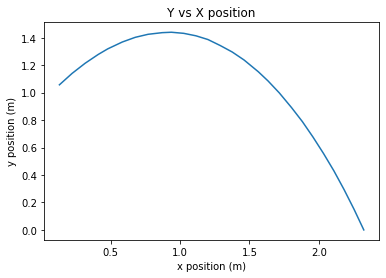

In [31]:
# Initial visualization of the data
plt.plot(df['x'], df['y'])
plt.xlabel("x position (m)")
plt.ylabel("y position (m)")
plt.title("Y vs X position")

Text(0.5, 1.0, 'Y position vs time')

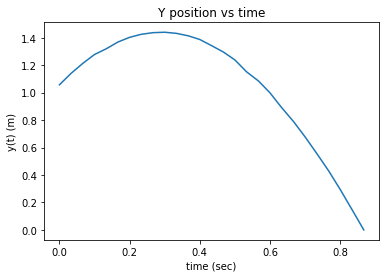

In [32]:
plt.plot(df['t'], df['y'])
plt.xlabel("time (sec)")
plt.ylabel("y(t) (m)")
plt.title("Y position vs time")

Text(0.5, 1.0, 'X position vs time')

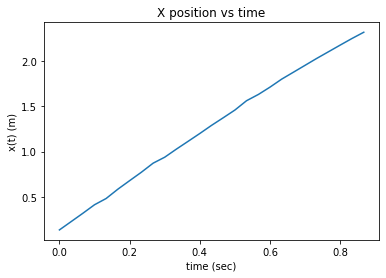

In [33]:
plt.plot(df['t'], df['x'])
plt.xlabel("time (sec)")
plt.ylabel("x(t) (m)")
plt.title("X position vs time")

## Simulation Helpers

In [34]:
# Constants
g   = 9.8               # gravity (m/s^2)

t0  = 0                 # initial Time (s) 
dt  = .033              # time resolution

tf  = 0.867             # total time to simulate
nsteps = int(tf/dt) + 1 # number of time steps

# data converted to matrix forms
x_data = df['x'].values
y_data = df['y'].values
t_data = df['t'].values



In [35]:
# Calculate inital conditions based on two given (early) coordinate points
def initial_conditions(coord1, coord2):
    t    = coord2[0] - coord1[0]
    x    = coord2[1] - coord1[1]
    y    = coord2[2] - coord1[2]
    return [x/t, y/t, coord1[1], coord1[2]]

## Euler Method
---

In [36]:
# Initial Conditions
 
# Getting initial velocity components
i_coord = initial_conditions(df.loc[0], df.loc[1])

print("X vel:", i_coord[0], "m/s")
print("Y vel:", i_coord[1], "m/s")
print("X pos:", i_coord[2], "m")
print("Y pos:", i_coord[3], "m")

y0  = i_coord[3]        # initial y (m)
x0  = i_coord[2]        # initial x (m)

vy0 = i_coord[1]        # iniital y velocity (m/s)
vx0 = i_coord[0]        # initial x velocity (m/s)

X vel: 2.7575757575757573 m/s
Y vel: 2.515151515151514 m/s
X pos: 0.132 m
Y pos: 1.057 m


In [37]:
# Euler method setting up - time evolution
t = np.linspace(t0, tf, nsteps)

vx = np.zeros([nsteps])
vy = np.zeros([nsteps])
y  = np.zeros([nsteps])
x  = np.zeros([nsteps])

y[0]  = y0
x[0]  = x0
vy[0] = vy0
vx[0] = vx0

## time evolving
for i in range(0, nsteps-1):
    y[i+1]  = y[i] + dt * vy[i]
    vy[i+1] = vy[i] - dt * g

    x[i+1]  = x[i] + dt * vx[i]
    vx[i+1] = vx[i]


### Prediction Plots
---

In [70]:
def make_plot(pars, ftitle, x_err=[], y_err=[], flabel=[], faxis=['']*2, fsize=[6, 4]):
    # this will make sure we don't align labels incorrectly
    if flabel == []:
        flabel = ['']*len(pars)
    
    # handles what to do if errors given
    if not (x_err == [] and y_err == []):
        plt.errorbar(pars[0][0], pars[0][1], xerr=x_err, yerr=y_err, fmt='.')

    # create the fig
    fig = plt.figure(figsize=(fsize[0], fsize[1]))

    # loop through to plot all the given lines
    for i in range(len(pars)):
        plt.plot(pars[i][0], pars[i][1], label=flabel[i])

    # other parameters for the plot
    plt.title(ftitle)
    plt.xlabel(faxis[0])
    plt.ylabel(faxis[1])
    plt.legend()

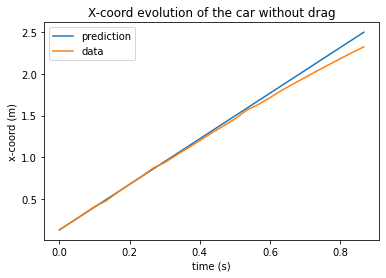

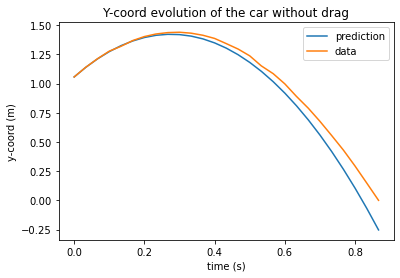

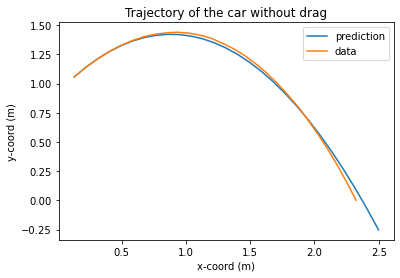

In [71]:
make_plot([[t, x], [t_data, x_data]],
          "X-coord evolution of the car without drag",
          flabel=["prediction", "data"],
          faxis=["time (s)", "x-coord (m)"])

make_plot([[t, y], [t_data, y_data]],
          "Y-coord evolution of the car without drag",
          flabel=["prediction", "data"],
          faxis=["time (s)", "y-coord (m)"])

make_plot([[x, y], [x_data, y_data]],
          "Trajectory of the car without drag",
          flabel=["prediction", "data"],
          faxis=["x-coord (m)", "y-coord (m)"])

### Error
---

In [72]:
def err(actual, expected):
    if not len(actual) == len(expected):
        return "number of data points do not match"
    else:
        return [round(abs(actual[i] - expected[i]), 5) if actual[i] > 0 and expected[i] > 0 else 0 for i in range(len(actual)) ]

In [44]:
x_pred = x
y_pred = y

x_err = err(x_data, x_pred)
y_err = err(y_data, y_pred)

### Error Plots

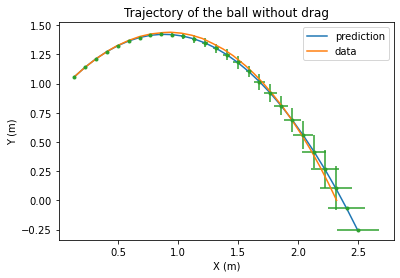

In [45]:
fig = plt.figure(figsize=(6, 4))
plt.plot(x,y, label="prediction")
plt.plot(df['x'], df['y'], label="data")
plt.errorbar(x, y, 
             xerr = x_err,
             yerr = y_err,
             fmt='.')
plt.title('Trajectory of the ball without drag')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.legend()

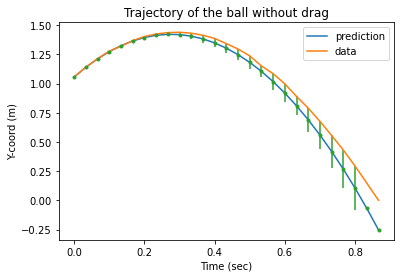

In [46]:
plt.plot(t, y, label="prediction")
plt.plot(df['t'], df['y'], label = "data")
plt.title('Trajectory of the ball without drag')
plt.xlabel('Time (sec)')
plt.ylabel('Y-coord (m)')
plt.legend()
plt.errorbar(t, y, yerr=y_err, fmt='.')
plt.show()

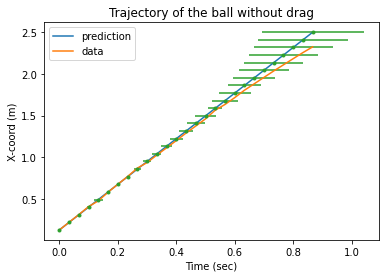

In [47]:
plt.plot(t, x, label="prediction")
plt.plot(df['t'], df['x'], label="data")
plt.plot()
plt.title('Trajectory of the ball without drag')
plt.xlabel('Time (sec)')
plt.ylabel('X-coord (m)')
plt.errorbar(t, x, xerr=x_err, fmt='.')
plt.legend()
plt.show()

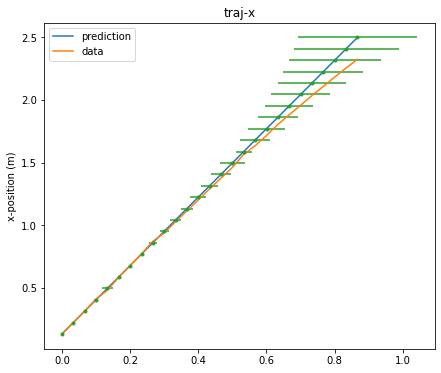

In [48]:
def make_plot(pars, ftitle, x_err=[], y_err=[], flabel=[], faxis=['']*2, fsize=[6, 4]):
    # this will make sure we don't align labels incorrectly
    if flabel == []:
        flabel = ['']*len(pars)
    if y_err == []:
        y_err = [0]*len(pars[0][1])
    if x_err == []:
        x_err = [0]*len(pars[0][0])

    # create the fig
    fig = plt.figure(figsize=(fsize[0], fsize[1]))

    # loop through to plot all the given lines
    for i in range(len(pars)):
        plt.plot(pars[i][0], pars[i][1], label=flabel[i])

    # other parameters for the plot
    plt.title(ftitle)
    plt.ylabel(faxis[1])
    plt.errorbar(pars[0][0], pars[0][1], xerr=x_err, yerr=y_err, fmt='.')
    plt.legend()

make_plot([[t, x], [t_data, x_data]],       # data plotting (pars)
          "traj-x",
          x_err,
          flabel=["prediction", "data"],
          faxis=["time (sec)", "x-position (m)"],
          fsize=[7, 6])

## Bashforth-Adams
---

The bashforth-adams algorithm is apparently an improvement on the Euler
algorithm so we will make an attempt at comparing them here

For a given position component, we have: <br>
$$ y_{n+1} = y_n + \frac{3}{2} \delta t f\left(t_n,y_n\right) - \frac{1}{2} \delta t f\left(t_{n-1},y_{n-1}\right)$$

Here the function $f$ is the derivative of the position component in question, thus we will be initializing it as the velocity.

In [49]:
# BA Initial Conditions

i_coord0 = initial_conditions(df.loc[0], df.loc[1])
i_coord1 = initial_conditions(df.loc[1], df.loc[2])
    
# note that we are gathering two initial position coordinates for BA
y0  = i_coord0[3]        # initial y (m)
x0  = i_coord0[2]        # initial x (m)
vy0 = i_coord0[1]        # iniital y velocity (m/s)
vx0 = i_coord0[0]        # initial x velocity (m/s)

y1  = i_coord1[3]        # initial +1 y (m)
x1  = i_coord1[2]        # initial +1 x (m)
vy1 = i_coord1[1]        # iniital +1 y velocity (m/s)
vx1 = i_coord1[0]        # initial +1 x velocity (m/s)

print(i_coord0, '\n', i_coord1)


[2.7575757575757573, 2.515151515151514, 0.132, 1.057] 
 [2.764705882352941, 2.1764705882352957, 0.223, 1.14]


In [50]:
# Bashforth-Adams method setting up - time evolution
t = np.linspace(t0, tf, nsteps)

vy_ba = np.zeros([nsteps])
vx_ba = np.zeros([nsteps])
y_ba  = np.zeros([nsteps])
x_ba  = np.zeros([nsteps])

# Init time 0 and 1
y_ba[0]  = y0
x_ba[0]  = x0
y_ba[1]  = y1
x_ba[1]  = x1
vy_ba[0] = vy0
vx_ba[0] = vx0
vy_ba[1] = vy1
vx_ba[1] = vx1

In [51]:
# Time evolving
for i in range(0, nsteps-2):
    y_ba[i+2]  = y_ba[i+1] + dt * (3/2*vy_ba[i+1] - 1/2*vy_ba[i])
    vy_ba[i+2] = vy_ba[i+1] - dt * g

    x_ba[i+2]  = x_ba[i+1] + dt * (3/2*vx_ba[i+1] - 1/2*vx_ba[i])
    vx_ba[i+2] = vx_ba[i]


### Prediction Plots

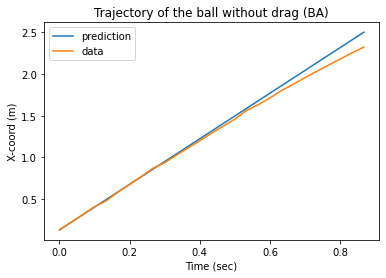

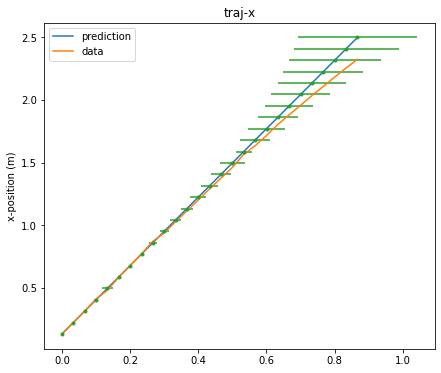

In [52]:
plt.plot(t, x_ba, label="prediction")
plt.plot(df['t'], df['x'], label="data")
plt.plot()
plt.title('Trajectory of the ball without drag (BA)')
plt.xlabel('Time (sec)')
plt.ylabel('X-coord (m)')
plt.legend()
plt.show()

make_plot([[t, x], [t_data, x_data]],       # data plotting (pars)
          "traj-x",
          x_err,
          flabel=["prediction", "data"],
          faxis=["time (sec)", "x-position (m)"],
          fsize=[7, 6])

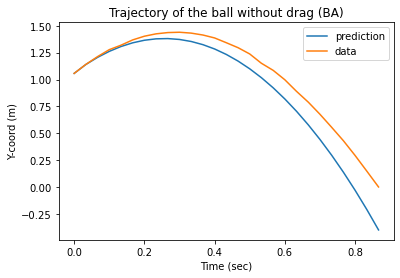

In [53]:
plt.plot(t, y_ba, label="prediction")
plt.plot(df['t'], df['y'], label = "data")
plt.title('Trajectory of the ball without drag (BA)')
plt.xlabel('Time (sec)')
plt.ylabel('Y-coord (m)')
plt.legend()
plt.show()

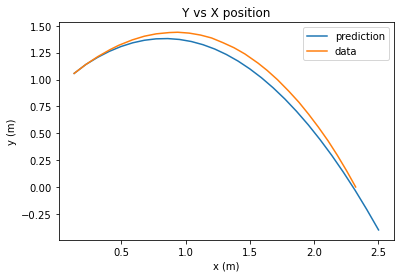

In [54]:
plt.plot(x_ba,y_ba, label="prediction")
plt.plot(df['x'], df['y'], label="data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Y vs X position")
plt.legend()